# Digitally controlled filter

Requirements:

- Input: float frequency_Hz, float sample_rate_Hz.
- Must be automatable (i.e. real time coefficient calculations).
- Must work as both a high-pass and low-pass filter.

References:

- [Apogee Filter Design Equations](http://www.apogeebio.com/ddx/PDFs/AN-06.pdf)

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal

SAMPLE_RATE_Hz = 44100
F_START_Hz = 20
F_STOP_Hz = 20e3
AMPLITUDE = 1.0
DURATION_s = 3.0

HP_TARGET_Hz = 5000.0
LP_TARGET_Hz = 15000.0

In [4]:
def get_chirp_frequency():
    return np.linspace(F_START_Hz, F_STOP_Hz, int(DURATION_s*SAMPLE_RATE_Hz))
    
def get_chirp():
    t = np.arange(int(DURATION_s*SAMPLE_RATE_Hz))/SAMPLE_RATE_Hz
    x = AMPLITUDE * scipy.signal.chirp(t, f0=F_START_Hz, f1=F_STOP_Hz, t1=max(t), method="linear")
    return np.array(x, dtype=float)

In [7]:
def calculate_coeffs(fc, low_pass=True):
    # Apogee Filter Design Equations
    Q = np.sqrt(1/2)
    fs = SAMPLE_RATE_Hz
    
    wc = 2*np.pi*fc/fs
    wS = np.sin(wc)
    wC = np.cos(wc)
    alpha = wS/(2*Q)
    
    a = np.zeros(3)
    b = np.zeros(3)
    
    a[0] = 1+alpha
    a[1] = -2*wC
    a[2] = 1-alpha
    
    if low_pass:
        b[0] = (1-wC)/2
        b[1] = 1-wC
        b[2] = b[0]
    else:
        b[0] = (1+wC)/2
        b[1] = -(1+wC)
        b[2] = b[0]

    return b, a
    
def apply_filter_lfilter(b, a, x_all):
    return scipy.signal.lfilter(b, a, x_all)

def apply_filter(b, a, x_all):
    N = len(x_all)
    y_all = np.zeros(N)
    
    # Delay lines (higher index -> higher delay)
    x = [0, 0, 0]
    y = [0, 0, 0]
    
    for n in range(N):
        x[0] = x_all[n]
        y[0] = b[0]*x[0] + b[1]*x[1] + b[2]*x[2] - a[1]*y[1] - a[2]*y[2]
        y[0] /= a[0]
        y_all[n] = y[0]
        
        x[2] = x[1]
        x[1] = x[0]
        
        y[2] = y[1]
        y[1] = y[0]
    
    return y_all

def lp_filter(x_all, fc):
    b, a = calculate_coeffs(fc, low_pass=True)
    return apply_filter(b, a, x_all)

def hp_filter(x_all, fc):
    b, a = calculate_coeffs(fc, low_pass=False)
    return apply_filter(b, a, x_all)

def nofilter(x_all):
    return apply_filter([1, 0, 0], [1, 0, 0], x_all)

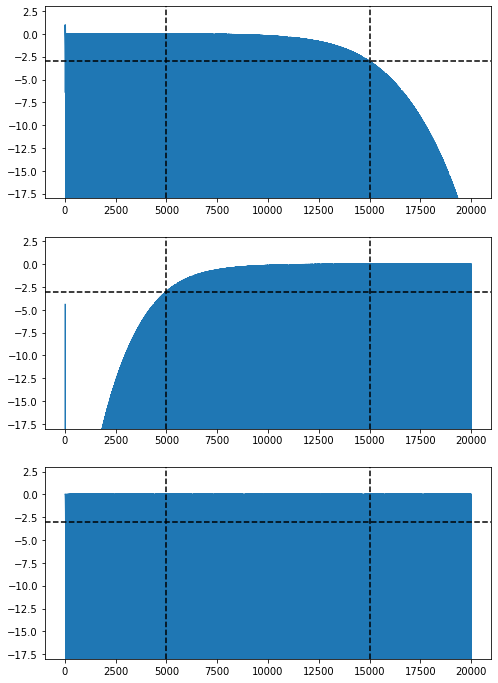

In [10]:
f = get_chirp_frequency()
x = get_chirp()
y1 = lp_filter(x, fc=LP_TARGET_Hz)
y2 = hp_filter(x, fc=HP_TARGET_Hz)
y3 = nofilter(x)

p = lambda ax, X: ax.plot(f, 20.0*np.ma.log10(np.abs(X)))

fig, axs = plt.subplots(3, 1, figsize=[8, 12])
p(axs[0], y1)
p(axs[1], y2)
p(axs[2], y3)

for ax in axs:
    for marker in [HP_TARGET_Hz, LP_TARGET_Hz]:
        ax.axvline(marker, color="black", linestyle="--")

    ax.axhline(-3, color="black", linestyle="--")
    ax.set_ylim(-18,3)